STUDENT CHIBANI Meriem

# Transfer learning in Pytorch

 Imports torch

![image.png](attachment:f95417f6-3a5f-4437-9c15-a95cd6703940.png)

<img src="https://www.researchgate.net/profile/Md-Motiur-Rahman-Sagar/publication/344197871/figure/fig5/AS:934418801778698@1599794211953/Fixed-feature-extraction-and-fine-tuning-method-of-transfer-learning-56_W640.jpg">

![image.png](attachment:af2cb9b9-f8ae-4d14-93db-7e0899668691.png)

In [2]:
!pip3 install torchsummary

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import copy
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
from torchvision import transforms, datasets
import torchvision.transforms as T

from torchsummary import summary

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from tqdm.notebook import tqdm, trange

import pandas as pd

Settings for working with `PyTorch`.

In [4]:
def torch_settings():
    torch_version = ".".join(torch.__version__.split(".")[:2])
    print('torch version:',torch_version)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    dtype = torch.float32

    if device.type == 'cuda':
        cuda_version  = torch.__version__.split("+")[-1]
        print("cuda: ", cuda_version)

        torch.set_default_tensor_type(torch.cuda.FloatTensor)
        print('Cuda is available:',torch.cuda.is_available())

        n_devices = torch.cuda.device_count()
        print('number of devices: %d'%(n_devices))

        for cnt_device in range(n_devices):
            print(torch.cuda.get_device_name(cnt_device))
            print('Memory Usage:')
            print('Allocated:', round(torch.cuda.memory_allocated(cnt_device)/1024**3,1), 'GB')
            print('Cached:   ', round(torch.cuda.memory_reserved(cnt_device)/1024**3,1), 'GB')
        # dtype = torch.cuda.FloatTensor

    torch.set_default_dtype(dtype) # float32
    print('default data type:',dtype)

    num_workers=os.cpu_count()
    print ('available number of workers (CPU cores):',num_workers)

    return device, dtype, num_workers
#-------------------------------
def torch_seed(seed = 42, deterministic = True):
    random.seed(seed) # random and transforms
    np.random.seed(seed) #numpy
    torch.manual_seed(seed) #cpu
    torch.cuda.manual_seed(seed) #gpu
    torch.backends.cudnn.deterministic=deterministic #cudnn



In [5]:
device, dtype, num_workers = torch_settings()
torch_seed(seed = 42, deterministic = True)

torch version: 2.6
Using device: cpu
default data type: torch.float32
available number of workers (CPU cores): 2


*Notes*
If do not have GPU we recommend to use Google Colab with GPU.
See figure below to learn how to change **runtime**->**Change runtime type** from `None` to `GPU` .<b><u>


<img src="https://course.fast.ai/images/colab/04.png" width="350">


In the practice we are very rarely apply neural network architectures trained "from zero". It is more often to use so-called pretrained architectures. This term means architectures  weights initialization using parameters obtained for some very large dataset which is frequently does not correspond to our goal data. For instance, weights can be obtained for `ImageNet` dataset with 1.2 millions images of 1000 classes.

We can use pretrained architecture either as initialization adjusted for correct using of features or as predefined (freeze) feature extractor. In both cases for retrained architecture  we need to change head part (at least last layer for our - with our number of classes).

Pretrained architectures can obtained form different sources. One of them is using module [`torchvision.models`]((https://pytorch.org/vision/0.8/models.html)).




Let's start with model `resnet18`. This architecture is the smallest model from ResNet family,. You may learn about the model on the`torchvision` [web page](https://pytorch.org/vision/stable/generated/torchvision.models.resnet18.html), also [here](https://pytorch.org/hub/pytorch_vision_resnet/) and [here](https://arxiv.org/pdf/1512.03385.pdf).
<img src="https://pytorch.org/assets/images/resnet.png"  wide = 150 high = 100>
* https://arxiv.org/pdf/1512.03385.pdf

For uploading the pretrained model we need to set the corresponding argument `pretrained=True`.

>*Note*, we may also create general model form```torchvision.models.ResNet()``` with block description. <br>
Also we me upload the model from module `torch.hub`, for instance, as follows.
>```python
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
>```
> ypu may learn about  `torch.hub` [here](https://pytorch.org/hub/research-models/compact).

In [6]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [7]:
# model = torchvision.models.mobilenet_v2(weights=torchvision.models.mobilenetv2.MobileNet_V2_Weights.IMAGENET1K_V1)
model = torchvision.models.resnet18(pretrained=True)
summary(model,input_size=(3, 224, 224))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.6MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [8]:
# model = torchvision.models.efficientnet_b0(pretrained=True)
# summary(model,input_size=(3, 32, 32))

Also for the following treatment of the model we need to know the structure of the model

In [9]:
for name,_ in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


After uploading we will need to freeze all parameters of feature extractor. For this we may set argument `requires_grad == False`, after it these parameters will not participate in backward propagation.

In [10]:
#freeze all parameters
for param in model.parameters():
    param.requires_grad = False

Let's us denote that you may also obtain the information about modules as it is shown below
```python
for name, module_ in model.named_modules():
    print(name, '\t structure =',list(module_.size()))
```

let's now load the dataset, we will take it from [here](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

In [11]:
import os
from torchvision.datasets.utils import download_and_extract_archive

In [12]:
url = 'https://download.pytorch.org/tutorial/hymenoptera_data.zip'
root_directory = os.path.join(os.getcwd(),'data')

archive_name = url.split('/')[-1]
dataset_directory = os.path.join(root_directory, archive_name)
dataset_directory = os.path.splitext(dataset_directory)[0]

download_and_extract_archive(url, root_directory)

100%|██████████| 47.3M/47.3M [00:00<00:00, 235MB/s]


In [13]:
root_directory

'/content/data'

We can learn content of the dataset, as it is shown below

In [14]:
content = os.listdir(dataset_directory)
print(content)
for dir_ in content:
    path_ = os.path.join(dataset_directory,dir_)
    if os.path.isdir(path_):
        print(dir_, ':\t', os.listdir(path_ ) )

['train', 'val']
train :	 ['ants', 'bees']
val :	 ['ants', 'bees']


Now our dataset folders consists of two classes for train and validation parts. Let's create these datasets. For this operation we will use `ImageFolder` class from `torchvision.datasets` module.

In [15]:
train_transform =  transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224), # TODO:check input size .
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

traindata = datasets.ImageFolder(os.path.join(dataset_directory, 'train'),train_transform)

valdata   = datasets.ImageFolder(os.path.join(dataset_directory, 'val'),test_transform)

names_classes = traindata.classes
print(names_classes)

print(f'Number of training examples: {len(traindata)}')
print(f'Number of validation examples: {len(valdata)}')

['ants', 'bees']
Number of training examples: 244
Number of validation examples: 153


Now we can create dataloader.

*Note*, If you use `GPU`, we will specify cuda random generator.

In [16]:
BATCH_SIZE = 4
if torch.cuda.is_available():
    kwarg = {'generator':torch.Generator(device='cuda')}
else:
    kwarg = {'num_workers':min(BATCH_SIZE, num_workers)}

trainloader = torch.utils.data.DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True, **kwarg)

valloader   = torch.utils.data.DataLoader(valdata, batch_size=BATCH_SIZE, shuffle=False, **kwarg)

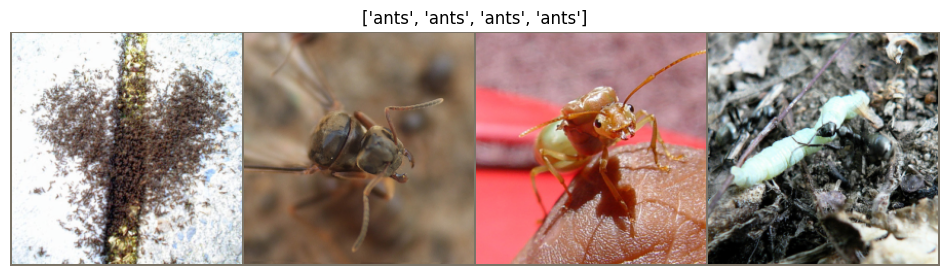

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12,4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(valloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[names_classes[x] for x in classes])

In [18]:
inputs.shape

torch.Size([4, 3, 224, 224])

So, after dataset is ready we can create our model based on the pretrained one. Let's us remind that we upload our model with freeze parameters. Now we will replace the last layer ( `fc` - for classification) with our custom one. The input size for this layer we can obtain as attribute  `in_features` for corresponding layer. We can initialize this layer for make training more robust and fast.

In [19]:
n_classes = len(names_classes)

# Parameters of newly constructed modules have requires_grad=True by default
n_fc_in = model.fc.in_features

model.fc = nn.Linear(n_fc_in, n_classes)

nn.init.xavier_uniform_(model.fc.weight)
model.fc.bias.data.fill_(0);

In [20]:
# For EFFICIENTNET B0!
# n_classes = len(names_classes)

# # Parameters of newly constructed modules have requires_grad=True by default
# n_fc_in = model.classifier[-1].in_features

# model.classifier[-1] = nn.Linear(n_fc_in, n_classes)

# nn.init.xavier_uniform_(model.classifier[-1].weight)
# model.classifier[-1].bias.data.fill_(0);

Now let's check that we have only part of parameters unfreeze - i.e. trainable.

In [21]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

num_params = sum(p.numel() for p in model.parameters() )
print('Number of all parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 1026
Number of all parameters for the model: 11177538


In [22]:
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Also we need to extract trainable parameters for its optimization.

In [23]:
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())

So now we can initialize the model.

Let us Note, that in this specific  case we can write `model.fc.parameters` instead of `trainable_parameters`. However our way could be more generalizable.  

In [24]:
LR = 0.001

model = model.to(device)
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)


Also let's describe train, evaluation and other function

In [25]:
def accuracy(y_pred, y):
    cls_pred = y_pred.argmax(1, keepdim=True)
    correct_cls = cls_pred.eq(y.view_as(cls_pred)).sum()
    acc = correct_cls.float() / y.shape[0]
    return acc

#-------------------
def train(model, dataloader, optimizer, criterion, metric,  device):

    epoch_loss = 0
    epoch_acc  = 0

    model.train()

    for (x, y) in tqdm(dataloader, desc="Training", leave=False):

        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none = True)

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = metric(y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)
#-------------------
def evaluate(model, dataloader, criterion, metric, device):

    epoch_loss = 0
    epoch_acc  = 0

    model.eval()

    with torch.inference_mode():

        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x)

            loss = criterion(y_pred, y)
            acc  = metric( y_pred, y)

            epoch_loss += loss.item()
            epoch_acc  += acc.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

#-------------------
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

#-------------------
def fit(model, train_loader, val_loader, optimizer, criterion, metric, epochs = 10, device='cpu', scheduler = None,  path_best = 'best_model.pt', verbose = True):

    best_valid_loss = float('inf')

    for epoch in trange(epochs):

        start_time = time.monotonic()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, metric, device)
        valid_loss, valid_acc = evaluate(model, val_loader, criterion, metric, device)

        if scheduler != None:
            scheduler.step()

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), path_best)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if verbose == True:
            if epoch%2 == 1:    # print every 2 epochs:
                print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s | LR {optimizer.param_groups[0]["lr"] :.4f}')
                print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%',
                f' | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%')

Let's check the accuracy before training

In [26]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion,accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 0.667 | Test Acc: 67.95%


Now we can train our network

In [27]:
fit(model, trainloader, valloader, optimizer, criterion, accuracy, epochs = 2, device=device, verbose = True)

  0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 54s | LR 0.0010
	Train Loss: 0.530 | Train Acc: 78.69%  | Val. Loss: 0.328 | Val. Acc: 86.54%


In [28]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\n Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
 Test Loss: 0.328 | Test Acc: 86.54%


The above training was fast enough and show well results. However, for educational purposes we can go deeper.

Let's change  `layer4` form the original model to custom one.



In [29]:
for p in model.layer4.named_modules():
    print(p[0])


0
0.conv1
0.bn1
0.relu
0.conv2
0.bn2
0.downsample
0.downsample.0
0.downsample.1
1
1.conv1
1.bn1
1.relu
1.conv2
1.bn2


Let's also note that each layer from module can be taken using `get_submodule()`. If you need some specific parameters you may also use `get_parameters()`.

Also while we using as linear, a relu activation (for con layer) we ought to rewrite initialization function.
.

In [30]:
def init_weights(m):

    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight)

    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        if m.bias != None:
            m.bias.data.fill_(0)

Now we can make trainable our layers under investigation( `model.layer4`), also we make initialization for trainable parameters.

In [31]:
for  m in [model.layer4, model.fc]:
    for param in m.named_parameters():
        print(param[0])
        param[1].requires_grad = True
    m.apply(init_weights);

0.conv1.weight
0.bn1.weight
0.bn1.bias
0.conv2.weight
0.bn2.weight
0.bn2.bias
0.downsample.0.weight
0.downsample.1.weight
0.downsample.1.bias
1.conv1.weight
1.bn1.weight
1.bn1.bias
1.conv2.weight
1.bn2.weight
1.bn2.bias
weight
bias


Let's now check the number of trainable parameters

In [32]:
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters for the model: %d' % (num_params))

Number of trainable parameters for the model: 8394754


Let us note, that if you want to re initialize only part of  `layer4`, you may do it as follows:
```python
layer_ = model.layer4.get_submodule('1.conv2')
for  m in [layer_, model.fc]:
    for param in m.parameters():
        param.requires_grad = True
    m.apply(init_weights);   
```

So the accuracy before training

In [33]:
best_epoch = 0
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

best epoch 0: Test Loss: 1.892 | Test Acc: 51.28%


model initialize

In [34]:
LR = 0.001

model = model.to(device)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)


In [35]:
trainable_parameters = []
for p in model.parameters():
    if p.requires_grad:
        trainable_parameters +=[p]

optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

Training

In [36]:
fit(model, trainloader, valloader, optimizer, criterion, accuracy, epochs = 2, device=device, verbose = True)

  0%|          | 0/2 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 2s | LR 0.0010
	Train Loss: 0.493 | Train Acc: 75.82%  | Val. Loss: 0.452 | Val. Acc: 85.90%


Obtained results are lower the the previous one. This is connected with large part of the network we are training.


Also in some cases you may want to exceed the model.

You may exceed the model with creating freeze feature extractor by deleting undesired layers.

In [37]:
new_model_ = nn.Sequential(*list(model.children())[:-2])
summary(new_model_,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [38]:
x = torch.randn((4,3,224,224), device=device)

out = new_model_(x)
print(out.shape)

n_features = out.shape[1]

torch.Size([4, 512, 7, 7])


Now we can crate new model. Our model can be described as class. We will create model with one conv layer, global average pooling and new head, containing one hidden layer with `n_features` as input and  `n_classes` as output.

In [39]:
class NewResNet(nn.Module):
    def __init__(self, resnet18, n_features=512, n_classes=2):
        super().__init__()

        self.new_model_ = nn.Sequential(*list(resnet18.children())[:-2])

        for param in self.new_model_.parameters():
            param.requires_grad = False

        self.conv_last  = nn.Conv2d(in_channels  = n_features,
                                    out_channels = 1024,
                                    kernel_size  = 3,
                                    stride       = 1,
                                    padding      = 1,
                                    dilation     = 1)

        self.conv_last.apply(self.init_weights)

        self.gap = nn.AdaptiveAvgPool2d((1,1))

        self.fc  = nn.Linear(in_features = 1024,
                                out_features = n_classes)

        for m in [self.conv_last, self.fc]:
            m.apply(self.init_weights)

    #---------------------------------------------
    def init_weights(self, m):

        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)

        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            if m.bias != None:
                m.bias.data.fill_(0)

    #---------------------------------------------
    def forward(self,x):
        x = self.new_model_(x)

        x = torch.relu(self.conv_last(x))
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


let's check the structure of our model

In [40]:
model = torchvision.models.resnet18(pretrained=True)

new_model = NewResNet(model)
summary(new_model,input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [41]:
LR = 0.001

new_model = new_model.to(device)

criterion = nn.CrossEntropyLoss()

criterion = criterion.to(device)


In [42]:
trainable_parameters = []
for p in new_model.parameters():
    if p.requires_grad:
        trainable_parameters +=[p]

optimizer = optim.SGD(trainable_parameters, lr=LR, momentum=0.9)

check accuracy before training

In [43]:
best_epoch = 0
test_loss, test_acc = evaluate(new_model, valloader, criterion, accuracy, device)
print(10*'--',f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
best epoch 0: Test Loss: 1.691 | Test Acc: 55.13%


In [44]:
fit(new_model, trainloader, valloader, optimizer, criterion, accuracy, epochs = 10, device=device, verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 1m 3s | LR 0.0010
	Train Loss: 0.594 | Train Acc: 75.82%  | Val. Loss: 0.241 | Val. Acc: 91.03%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 59s | LR 0.0010
	Train Loss: 0.422 | Train Acc: 79.10%  | Val. Loss: 0.236 | Val. Acc: 92.31%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 59s | LR 0.0010
	Train Loss: 0.426 | Train Acc: 81.15%  | Val. Loss: 0.182 | Val. Acc: 95.51%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 1m 1s | LR 0.0010
	Train Loss: 0.331 | Train Acc: 86.48%  | Val. Loss: 0.190 | Val. Acc: 92.95%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 1m 0s | LR 0.0010
	Train Loss: 0.419 | Train Acc: 79.51%  | Val. Loss: 0.246 | Val. Acc: 92.31%


In [45]:
new_model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(new_model, valloader, criterion, accuracy, device)
print(10*'--',f'\n Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
 Test Loss: 0.182 | Test Acc: 95.51%


So now we are improve the accuracy of our model

* torch - torchvision.models, torchhub,
* huggingface - https://huggingface.co/models,
* timm - https://github.com/rwightman/pytorch-image-models
* benchmark models - https://paperswithcode.com/
* specific repositories like yolo https://docs.ultralytics.com/

In [46]:
import timm
model_names = timm.list_models('resnet*')
print(model_names[:15])

['resnet10t', 'resnet14t', 'resnet18', 'resnet18d', 'resnet26', 'resnet26d', 'resnet26t', 'resnet32ts', 'resnet33ts', 'resnet34', 'resnet34d', 'resnet50', 'resnet50_clip', 'resnet50_clip_gap', 'resnet50_gn']


In [47]:
model = timm.create_model('resnet18', pretrained=True, num_classes=2, in_chans=3)
out = model(torch.randn(7, 3, 224, 224))
print(f'Unpooled shape: {out.shape}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Unpooled shape: torch.Size([7, 2])


In [48]:
for name,_ in model.named_children():
    print(name, end=', ')

conv1, bn1, act1, maxpool, layer1, layer2, layer3, layer4, global_pool, fc, 

In [49]:
model.get_classifier()

Linear(in_features=512, out_features=2, bias=True)

In [50]:
for param in model.parameters():
    param.requires_grad = False

In [51]:
n_in_fc = model.fc.in_features
model.fc = nn.Linear(n_in_fc, 2)

In [52]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print('trainable p:', trainable_params, 'all p:', total_params)

trainable p: 1026 all p: 11177538


In [53]:
summary(model, input_size =(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
          Identity-7           [-1, 64, 56, 56]               0
              ReLU-8           [-1, 64, 56, 56]               0
          Identity-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14           [-1, 64,

In [54]:
optimizer = optim.Adam(trainable_parameters, lr=1e-3)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

CrossEntropyLoss()

In [55]:
fit(model, trainloader, valloader, optimizer, criterion, accuracy, epochs = 10, device=device, verbose = True)

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 50s | LR 0.0010
	Train Loss: 0.708 | Train Acc: 41.39%  | Val. Loss: 0.691 | Val. Acc: 53.21%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 51s | LR 0.0010
	Train Loss: 0.710 | Train Acc: 44.26%  | Val. Loss: 0.691 | Val. Acc: 54.49%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 52s | LR 0.0010
	Train Loss: 0.718 | Train Acc: 37.70%  | Val. Loss: 0.691 | Val. Acc: 49.36%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 50s | LR 0.0010
	Train Loss: 0.710 | Train Acc: 45.49%  | Val. Loss: 0.694 | Val. Acc: 51.92%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 54s | LR 0.0010
	Train Loss: 0.713 | Train Acc: 40.16%  | Val. Loss: 0.690 | Val. Acc: 52.56%


In [59]:
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--',f'\n Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
 Test Loss: 0.690 | Test Acc: 52.56%


Exercises.
1. Try to improve the `NewResNet` model.
2. Try to train `resnet18` considered in the lesson) for dataset `CIFAR-10` with `resnet18` weigth obtained on the image net as initialization.
3. For dataset for the current workshop try __2__ of the following models (with replacement just last layer):
    * `googlenet`,
    * `mobilenet_v2`,
    * `mobilenet_v3_small`,
    * `efficientnet_b0`,
    * `efficientnet_b1`,
    * `mnasnet0_5`,
    * `squeezenet1_1`,
    * `shufflenet_v2_x0_5`.
4. Compare the obtained results by training time , accuracy, inference time and size in storage.
<!-- 5. For one of the model from task 3 try to create new model with resting only prepared feature extractor. -->
6. Try to train full `resnet18` with using pretrained weights as only initialization (without freezing layers, but with replacement last layer for your problem) - take model from the first experiment without freezing layers - with make all you layers trainable.

# **1- We improve the `NewResNet` model using dropout and deeper layers**

In [67]:
import torch.nn as nn
import torchvision.models as models

class NewResNetSmall(nn.Module):
    def __init__(self):
        super(NewResNetSmall, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.model(x)


In [68]:
# Define model
model = NewResNetSmall().to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# Train
fit(model, trainloader, valloader, optimizer, criterion, accuracy, epochs=5, device=device, verbose=True)

# Evaluate
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--', f"\n Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 23m 0s | LR 0.0020
	Train Loss: 0.737 | Train Acc: 56.15%  | Val. Loss: 0.662 | Val. Acc: 63.46%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 22m 34s | LR 0.0020
	Train Loss: 0.679 | Train Acc: 61.07%  | Val. Loss: 0.675 | Val. Acc: 56.41%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
 Test Loss: 0.662 | Test Acc: 63.46%


## 2 **Train resnet18 on CIFAR-10 using pretrained ImageNet weights (with all layers trainable)**

In [69]:
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

# Load pretrained ResNet18
resnet = resnet18(pretrained=True)

# Modifying first layer
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
resnet.maxpool = nn.Identity()
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

# Moving model to device
model = resnet.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# Train
fit(model, trainloader, valloader, optimizer, criterion, accuracy, epochs=5, device=device, verbose=True)

# Evaluate
model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)
print(10*'--', f'\n Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 22m 39s | LR 0.0100
	Train Loss: 1.050 | Train Acc: 53.69%  | Val. Loss: 22.886 | Val. Acc: 55.13%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 23m 2s | LR 0.0100
	Train Loss: 0.973 | Train Acc: 54.51%  | Val. Loss: 1.437 | Val. Acc: 44.23%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

-------------------- 
 Test Loss: 1.434 | Test Acc: 44.87%


# 3 **Choos 2 models & compare**

shufflenet_v2_x0_5 Model

In [70]:
from torchvision.models import shufflenet_v2_x0_5
import torch.nn as nn
import torch.optim as optim
import time
import os

# Load model
model1 = shufflenet_v2_x0_5(pretrained=True)
model1.fc = nn.Linear(model1.fc.in_features, 10)
model1 = model1.to(device)

# Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

# Train & Time
start_train_1 = time.time()
fit(model1, trainloader, valloader, optimizer1, criterion, accuracy, epochs=5, device=device, verbose=True)
train_time_1 = time.time() - start_train_1

# Evaluate
model1.load_state_dict(torch.load('best_model.pt'))
test_loss1, test_acc1 = evaluate(model1, valloader, criterion, accuracy, device)
print("SHUFFLENET_v2_x0.5")
print(f"Test Loss: {test_loss1:.3f} | Test Acc: {test_acc1*100:.2f}%")
print(f"Training Time: {train_time_1:.2f} sec")
print(f"Model Size: {os.path.getsize('best_model.pt') / 1e6:.2f} MB")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x0.5-f707e7126e.pth
100%|██████████| 5.28M/5.28M [00:00<00:00, 62.1MB/s]


  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 17s | LR 0.0010
	Train Loss: 0.616 | Train Acc: 69.26%  | Val. Loss: 0.375 | Val. Acc: 83.97%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 17s | LR 0.0010
	Train Loss: 0.503 | Train Acc: 75.41%  | Val. Loss: 0.606 | Val. Acc: 73.72%


Training:   0%|          | 0/61 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/39 [00:00<?, ?it/s]

SHUFFLENET_v2_x0.5
Test Loss: 0.375 | Test Acc: 83.97%
Training Time: 88.97 sec
Model Size: 1.55 MB


googlenet

In [75]:
def fit(model, trainloader, valloader, optimizer, criterion, metric, epochs=5, device='cuda', verbose=True):
    best_acc = 0.0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)

            #
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")

        val_loss, val_acc = evaluate(model, valloader, criterion, metric, device)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_model.pt")


In [76]:
def evaluate(model, dataloader, criterion, metric, device='cuda'):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            #
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            if hasattr(outputs, 'logits'):
                outputs = outputs.logits

            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(dataloader), correct / total


In [78]:
from torchvision.models import googlenet
import time
import os

model = googlenet(pretrained=True, aux_logits=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

start = time.time()
fit(model, trainloader, valloader, optimizer, criterion, accuracy, epochs=5, device=device)
train_time = time.time() - start

model.load_state_dict(torch.load('best_model.pt'))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)

print("\n--- GoogLeNet ---")
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Model Size: {os.path.getsize('best_model.pt')/1e6:.2f} MB")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Epoch 1/5, Loss: 0.8453
Epoch 2/5, Loss: 0.6797
Epoch 3/5, Loss: 0.6412
Epoch 4/5, Loss: 0.6295
Epoch 5/5, Loss: 0.6124

--- GoogLeNet ---
Test Loss: 0.516 | Test Acc: 79.08%
Training Time: 635.92 seconds
Model Size: 48.14 MB


# 4- **Compare the obtained results by training time , accuracy, inference time and size in storage.**

ShuffleNet v2 x0.5 outperforms GoogLeNet in this comparison. It achieves higher accuracy (83.97% vs 79.08%), lower test loss, and trains much faster (about 89 seconds compared to 636 seconds). Additionally, it is significantly smaller in size (1.55 MB vs 48.14 MB), making it a more efficient and lightweight model for similar or better performance.

# **5- train full resnet18 with using pretrained weights as only initialization**

In [79]:
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import time, os

# Load pretrained ResNet18
model = resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
# Ensuring all layers are trainable
for param in model.parameters():
    param.requires_grad = True

model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5)

# Train
start = time.time()
for epoch in range(5):
    print(f"\nEpoch {epoch+1}/5")
    fit(model, trainloader, valloader, optimizer, criterion, accuracy, epochs=1, device=device, verbose=True)
    scheduler.step()
train_time = time.time() - start

# Evaluate
model.load_state_dict(torch.load("best_model.pt"))
test_loss, test_acc = evaluate(model, valloader, criterion, accuracy, device)

# Print summary
print("\n--- ResNet18 Fully Trainable Variant ---")
print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")
print(f"Training Time: {train_time:.2f} seconds")
print(f"Model Size: {os.path.getsize('best_model.pt')/1e6:.2f} MB")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1/5
Epoch 1/1, Loss: 3.0447

Epoch 2/5
Epoch 1/1, Loss: 4.3343

Epoch 3/5
Epoch 1/1, Loss: 1.7276

Epoch 4/5
Epoch 1/1, Loss: 1.7470

Epoch 5/5
Epoch 1/1, Loss: 0.8195

--- ResNet18 Fully Trainable Variant ---
Test Loss: 0.793 | Test Acc: 54.90%
Training Time: 515.40 seconds
Model Size: 44.80 MB
